# Análise Exploratória e Inferencial de Dados de E-commerce

**Equipe:** Levi Moraes e Thays Barbosa

Este notebook contém a análise exploratória de dados (EDA) e a análise inferencial (Intervalos de Confiança) para o e-commerce brasileiro, conforme solicitado pela direção. O objetivo é fornecer respostas confiáveis sobre receita, margens, frete, prazos de entrega e comportamento do cliente.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint
import statsmodels.stats.api as sms
import os

# Configuração do diretório de dados
charts_dir = "../../charts"
if not os.path.exists(charts_dir): os.makedirs(charts_dir)

# Carregar os dados
df_orders = pd.read_csv(os.path.join("../data/raw/FACT_Orders.csv"))
df_delivery = pd.read_csv(os.path.join("../data/raw/DIM_Delivery.csv"))
df_customer = pd.read_csv(os.path.join("../data/raw/DIM_Customer.csv"))
df_shopping = pd.read_csv(os.path.join("../data/raw/DIM_Shopping.csv"))
df_products = pd.read_csv(os.path.join("../data/raw/DIM_Products.csv"))

In [45]:
df_delivery = pd.read_csv(os.path.join("../data/raw/DIM_Delivery.csv"))
df_customer = pd.read_csv(os.path.join("../data/raw/DIM_Customer.csv"))
df_shopping = pd.read_csv(os.path.join("../data/raw/DIM_Shopping.csv"))
df_products = pd.read_csv(os.path.join("../data/raw/DIM_Products.csv"))

## 1. Qualidade e Preparação dos Dados

In [46]:
# Merge dos DataFrames
df_main = df_orders.merge(df_delivery, on='Id', how='left', suffixes=('_Order', '_Delivery'))
df_main = df_main.merge(df_customer, on='Id', how='left')

# Renomear colunas
df_main.rename(columns={
    'Id': 'Order_ID',
    'payment': 'Payment_Method',
    'P_Sevice': 'Freight_Cost',
    'Status': 'Delivery_Status',
    'Services': 'Delivery_Service',
    'Order_Id': 'Delivery_Order_Id'
}, inplace=True)


In [47]:

# Conversão de tipos (Datas)
date_cols = ['Order_Date', 'D_Date', 'D_Forecast']
for col in date_cols:
    df_main[col] = df_main[col].apply(lambda x: str(x).split('.')[0] if pd.notna(x) else x)
    df_main[col] = pd.to_datetime(df_main[col], errors='coerce')

# Trimming em strings
string_cols = ['Payment_Method', 'Purchase_Status', 'Delivery_Service', 'Delivery_Status', 'UF', 'Region']
for col in string_cols:
    if col in df_main.columns:
        df_main[col] = df_main[col].astype(str).str.strip()

# Tratamento de NAs e Duplicatas
df_main.dropna(subset=['Order_Date'], inplace=True)
df_main.drop_duplicates(subset=['Order_ID'], inplace=True)


In [48]:

# Engenharia de Features (KPIs)
df_main['delivery_delay_days'] = (df_main['D_Date'] - df_main['D_Forecast']).dt.days
df_main['delivery_lead_time'] = (df_main['D_Date'] - df_main['Order_Date']).dt.days


In [49]:
df_main['is_late'] = (df_main['D_Date'] > df_main['D_Forecast']).astype(int)
df_main['is_confirmed'] = (df_main['Purchase_Status'] == "Confirmado").astype(int)


In [50]:
df_main['Freight_Cost'] = pd.to_numeric(df_main['Freight_Cost'], errors='coerce')
df_main['Total'] = pd.to_numeric(df_main['Total'], errors='coerce')

df_main['Freight_Cost'].fillna(0)
df_main['Total'].fillna(0)

0       3586.28
1       1636.64
2       2019.82
3        237.23
4        193.33
         ...   
1995    2317.95
1996     748.38
1997     266.86
1998    8497.69
1999     141.81
Name: Total, Length: 2000, dtype: float64

In [51]:
df_main['freight_share'] = (df_main['Freight_Cost'] / df_main['Total'])

In [52]:
df_main['discount_abs'] = df_main['Discount'] * df_main['Subtotal']
df_main['Order_Month'] = df_main['Order_Date'].dt.month
df_main['Order_Year'] = df_main['Order_Date'].dt.year

In [53]:

# Preparação para Mix (Merge Shopping e Products)
df_mix = df_shopping.merge(df_products, left_on='Product', right_on='Product_Name', how='left', suffixes=('_Item', '_Product'))
df_mix.rename(columns={'Id_Item': 'Shopping_ID', 'Id_Product': 'Product_ID_Dim', 'Price_Item': 'Item_Price_Shopping', 'Price_Product': 'Item_Price_Product'}, inplace=True)
df_mix.rename(columns={'Shopping_ID': 'Order_ID'}, inplace=True)

# Merge final
df_final = df_main.merge(df_mix[['Order_ID', 'Category', 'Subcategory', 'Quantity', 'Item_Price_Product']], on='Order_ID', how='left')

print("Primeiras 5 linhas do DataFrame Final:")
df_final.head()

Primeiras 5 linhas do DataFrame Final:


,Order_ID,Order_Date,Discount,Subtotal,Total,Payment_Method,Purchase_Status,Delivery_Id,Delivery_Service,Freight_Cost,...,is_late,is_confirmed,freight_share,discount_abs,Order_Month,Order_Year,Category,Subcategory,Quantity,Item_Price_Product
0,1,2025-04-12 00:52:33,0.1048,3958.20,3586.28,Credito,Processando,D00001,Same-Day,42.9,...,0,0,0.011962,414.819360,4,2025,Eletrônicos,"Celulares, Tablets e Acessórios",2,1979.10
1,2,2025-05-05 01:02:38,0.1141,1799.01,1636.64,PIX,Em Analise,D00002,Same-Day,42.9,...,1,0,0.026212,205.267041,5,2025,Eletrônicos,"Celulares, Tablets e Acessórios",1,1799.01
2,3,2025-04-27 23:05:38,0.0686,2144.00,2019.82,Boleto,Cancelado,D00003,Standard,22.9,...,0,0,0.011338,147.078400,4,2025,Eletrônicos,Áudio e Vídeo,2,1072.00
3,4,2025-04-10 02:42:52,0.0264,199.60,237.23,Debito,Processando,D00004,Same-Day,42.9,...,1,0,0.180837,5.269440,4,2025,Eletrônicos,"Celulares, Tablets e Acessórios",4,49.90
4,5,2025-05-12 21:55:33,0.0697,161.70,193.33,Credito,Em Analise,D00005,Same-Day,42.9,...,1,0,0.221900,11.270490,5,2025,Eletrônicos,"Celulares, Tablets e Acessórios",3,53.90


## 2. Análise Descritiva (EDA)

In [54]:
# Medidas de Tendência Central e Dispersão
descriptive_stats = df_final[["Total", "delivery_lead_time", "Discount", "Freight_Cost", "delivery_delay_days"]].describe()
print("Estatísticas Descritivas:")
print(descriptive_stats.to_markdown())

Estatísticas Descritivas:
|       |    Total |   delivery_lead_time |     Discount |   Freight_Cost |   delivery_delay_days |
|:------|---------:|---------------------:|-------------:|---------------:|----------------------:|
| count |  1999    |            2000      | 2000         |     2000       |            2000       |
| mean  |  2503.19 |              30.547  |    0.0742115 |       32.6309  |               2.5305  |
| std   |  3230.51 |              27.3052 |    0.0427026 |        8.10328 |               1.73193 |
| min   |    38.54 |             -29      |    0.0001    |       22.9     |               0       |
| 25%   |   250.24 |               8      |    0.0378    |       22.9     |               1       |
| 50%   |  1221.2  |              31.5    |    0.07435   |       32.99    |               3       |
| 75%   |  3479.93 |              53      |    0.111725  |       42.9     |               4       |
| max   | 18349.5  |              88      |    0.15      |       42.9     

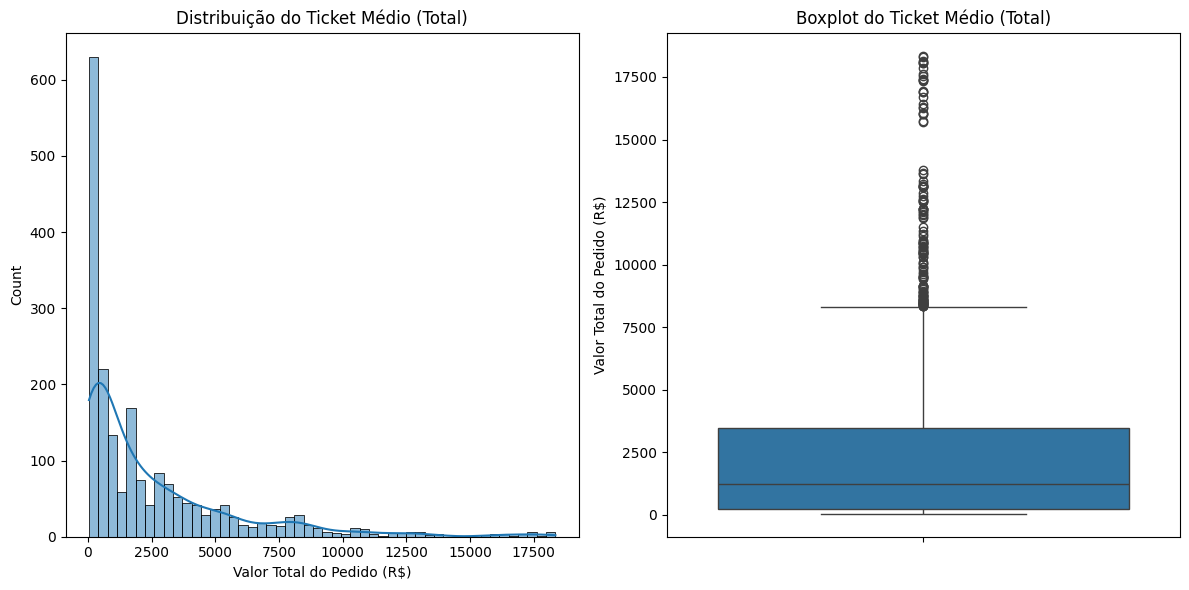

In [55]:
# Histograma e Boxplot para Ticket Médio (Total)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_final["Total"], kde=True, bins=50)
plt.title("Distribuição do Ticket Médio (Total)")
plt.xlabel("Valor Total do Pedido (R$)")

plt.subplot(1, 2, 2)
sns.boxplot(y=df_final["Total"])
plt.title("Boxplot do Ticket Médio (Total)")
plt.ylabel("Valor Total do Pedido (R$)")
plt.tight_layout()
plt.savefig(os.path.join(charts_dir, "ticket_distribution.png"))
plt.show()

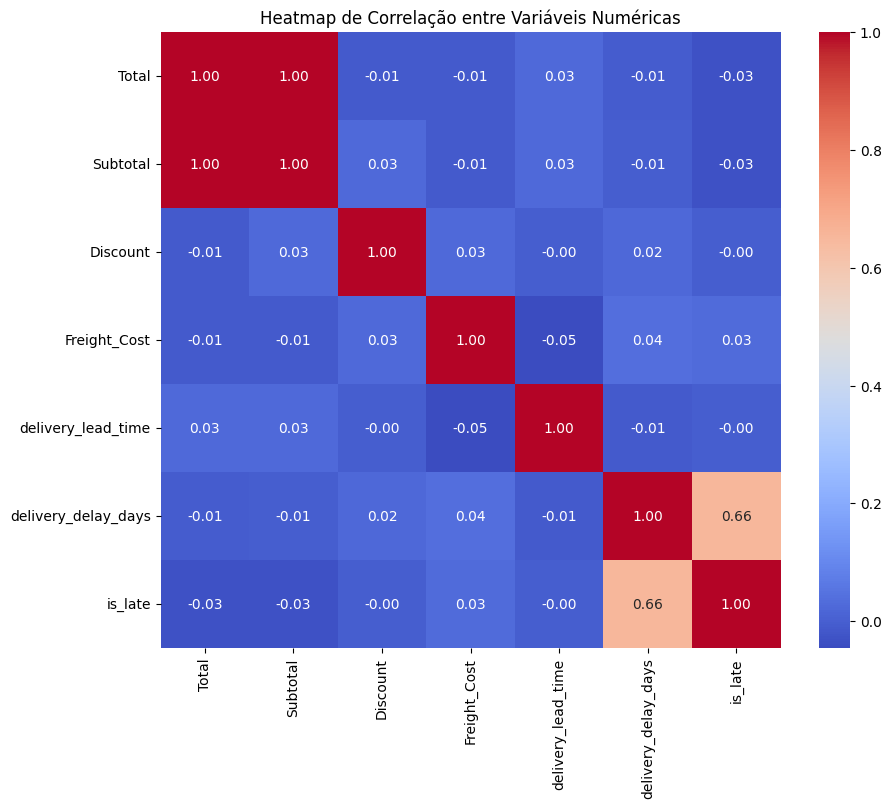

In [56]:
# Heatmap de Correlação
corr_cols = df_final[["Total", "Subtotal", "Discount", "Freight_Cost", "delivery_lead_time", "delivery_delay_days", "is_late"]]
correlation_matrix = corr_cols.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap de Correlação entre Variáveis Numéricas")
plt.savefig(os.path.join(charts_dir, "correlation_heatmap.png"))
plt.show()

C:\Users\tbsc_cesar\AppData\Local\Temp\ipykernel_15044\310821525.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_revenue = df_final["Total"].resample("M").sum()


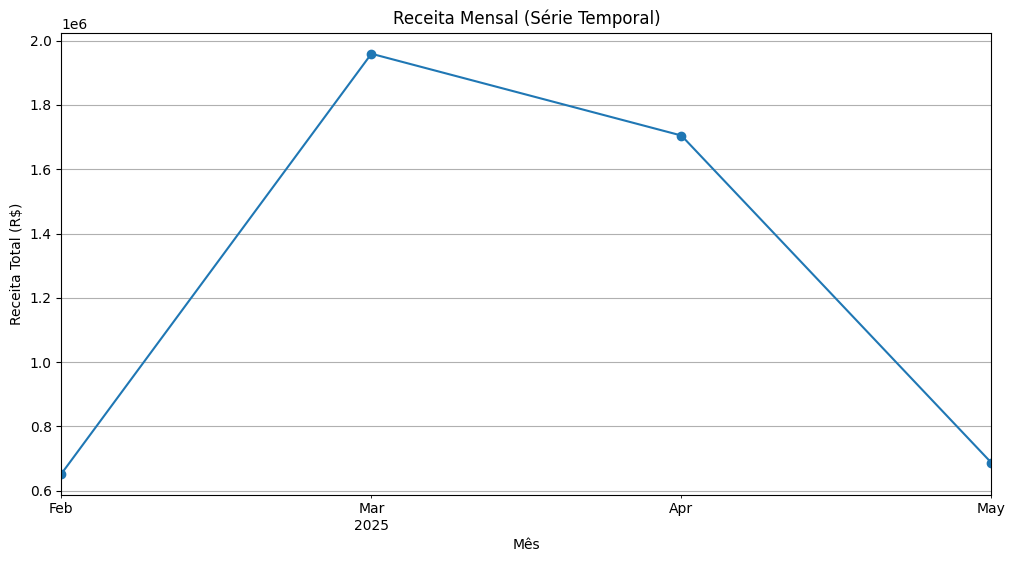

In [57]:
# Série Temporal Mensal da Receita
df_final.set_index("Order_Date", inplace=True)
monthly_revenue = df_final["Total"].resample("M").sum()

plt.figure(figsize=(12, 6))
monthly_revenue.plot(kind="line", marker="o")
plt.title("Receita Mensal (Série Temporal)")
plt.xlabel("Mês")
plt.ylabel("Receita Total (R$)")
plt.grid(True)
plt.savefig(os.path.join(charts_dir, "monthly_revenue.png"))
plt.show()

df_final.reset_index(inplace=True)

## 3. Análise Inferencial (Intervalos de Confiança)

In [58]:
# IC 95% para Ticket Médio (Total)
ci_total = sms.DescrStatsW(df_final['Total']).tconfint_mean(alpha=0.05)
print("--- Intervalo de Confiança 95% para Ticket Médio (Total) ---")
print(f"Média: R$ {df_final['Total'].mean():.2f}")
print(f"IC 95%: (R$ {ci_total[0]:.2f}, R$ {ci_total[1]:.2f})")

# IC 95% para Proporção de Atraso (is_late)
count_late = df_final['is_late'].sum()
n_late = len(df_final['is_late'])
prop_late = count_late / n_late
ci_prop_late = proportion_confint(count_late, n_late, alpha=0.05, method='normal')
print("\n--- Intervalo de Confiança 95% para Proporção de Atraso ---")
print(f"Proporção de Atraso: {prop_late:.4f} ({prop_late*100:.2f}%)")
print(f"IC 95% (Normal): ({ci_prop_late[0]:.4f}, {ci_prop_late[1]:.4f})")

# IC 95% para Proporção de Cancelamento
count_cancelled = (df_final['Purchase_Status'] == "Cancelado").sum()
n_cancelled = len(df_final['Purchase_Status'])
prop_cancelled = count_cancelled / n_cancelled
ci_prop_cancelled = proportion_confint(count_cancelled, n_cancelled, alpha=0.05, method='normal')
print("\n--- Intervalo de Confiança 95% para Proporção de Cancelamento ---")
print(f"Proporção de Cancelamento: {prop_cancelled:.4f} ({prop_cancelled*100:.2f}%)")
print(f"IC 95% (Normal): ({ci_prop_cancelled[0]:.4f}, {ci_prop_cancelled[1]:.4f})")

--- Intervalo de Confiança 95% para Ticket Médio (Total) ---
Média: R$ 2503.19
IC 95%: (R$ nan, R$ nan)

--- Intervalo de Confiança 95% para Proporção de Atraso ---
Proporção de Atraso: 0.8325 (83.25%)
IC 95% (Normal): (0.8161, 0.8489)

--- Intervalo de Confiança 95% para Proporção de Cancelamento ---
Proporção de Cancelamento: 0.2580 (25.80%)
IC 95% (Normal): (0.2388, 0.2772)


## 4. KPIs e Insights

In [59]:
# Conversão de Pagamento (por payment)
payment_conversion = df_final.groupby('Payment_Method')['is_confirmed'].agg(['sum', 'count'])
payment_conversion['Conversion_Rate'] = payment_conversion['sum'] / payment_conversion['count']
print("Conversão de Pagamento por Método:")
print(payment_conversion.to_markdown())

Conversão de Pagamento por Método:
| Payment_Method   |   sum |   count |   Conversion_Rate |
|:-----------------|------:|--------:|------------------:|
| Boleto           |   118 |     510 |          0.231373 |
| Credito          |   126 |     488 |          0.258197 |
| Debito           |   121 |     515 |          0.234951 |
| PIX              |   133 |     487 |          0.273101 |


In [60]:
# Performance Logística por Services
logistics_performance = df_final.groupby('Delivery_Service').agg(
    Avg_Lead_Time=('delivery_lead_time', 'mean'),
    Late_Rate=('is_late', 'mean'),
    Total_Orders=('Order_ID', 'count')
)
print("Performance Logística por Serviço:")
print(logistics_performance.to_markdown())

Performance Logística por Serviço:
| Delivery_Service   |   Avg_Lead_Time |   Late_Rate |   Total_Orders |
|:-------------------|----------------:|------------:|---------------:|
| Same-Day           |         28.3078 |    0.84051  |            627 |
| Scheduled          |         31.6312 |    0.842566 |            686 |
| Standard           |         31.508  |    0.815138 |            687 |


In [61]:
# Mix por Category/Subcategory e elasticidade vs desconto
df_mix_agg = df_final.groupby(['Category', 'Subcategory']).agg(
    Total_Quantity=('Quantity', 'sum'),
    Avg_Discount=('Discount', 'mean'),
    Total_Revenue=('Total', 'sum')
).reset_index()

print("Mix de Produtos (Top 5 por Receita):")
print(df_mix_agg.sort_values(by='Total_Revenue', ascending=False).head(5).to_markdown())

Mix de Produtos (Top 5 por Receita):
|    | Category    | Subcategory                     |   Total_Quantity |   Avg_Discount |    Total_Revenue |
|---:|:------------|:--------------------------------|-----------------:|---------------:|-----------------:|
|  2 | Eletrônicos | Áudio e Vídeo                   |             1910 |      0.0737859 |      2.46351e+06 |
|  1 | Eletrônicos | Informática                     |             1151 |      0.0738026 |      1.60533e+06 |
|  0 | Eletrônicos | Celulares, Tablets e Acessórios |             1946 |      0.0748716 | 935025           |


In [62]:
# Sazonalidade por Região
regional_revenue = df_final.groupby('Region')['Total'].sum().sort_values(ascending=False)
print("Receita por Região:")
print(regional_revenue.to_markdown())

Receita por Região:
| Region   |       Total |
|:---------|------------:|
| Nordeste | 1.34902e+06 |
| Sul      | 1.2646e+06  |
| Sudeste  | 1.23911e+06 |
| Norte    | 1.15114e+06 |
